<a href="https://colab.research.google.com/github/Krishnakanth1993/TASAI_ERA/blob/main/MNIST_Model/Notebooks/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [3]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

CUDA Available? True


# **Understanding the Data**

In [12]:
# Load MNIST training data without normalization
train_data = datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor())
train_loader = DataLoader(train_data, batch_size=512, shuffle=False)

# Compute mean and std
mean = 0.0
std = 0.0
total_images = 0

for images, _ in train_loader:
    batch_samples = images.size(0)  # Number of images in batch
    images = images.view(batch_samples, -1)  # Flatten: [batch_size, 1, 28, 28] -> [batch_size, 784]
    mean += images.mean(dim=1).sum().item()  # Sum mean across pixels for each image
    std += images.std(dim=1).sum().item()  # Sum std across pixels for each image
    total_images += batch_samples

mean /= total_images
std /= total_images

print(f'Mean: {mean:.4f}, Std: {std:.4f} ,Total_images: {total_images}')

Mean: 0.1307, Std: 0.3015 ,Total_images: 60000


In [7]:
dataloader_iterator = iter(train_loader)
batch_data = next(dataloader_iterator)

for item in batch_data:
  if isinstance(item, torch.Tensor):
      #print(item)
      print(f"Shape of a tensor in the batch: {item.shape}")
  else:
      #print(item)
      print(f"Type of item in batch: {type(item)}")

Shape of a tensor in the batch: torch.Size([512, 1, 28, 28])
Shape of a tensor in the batch: torch.Size([512])


# **Data Loading & Preprocessing**

In [14]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

In [17]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=test_transforms)

In [18]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

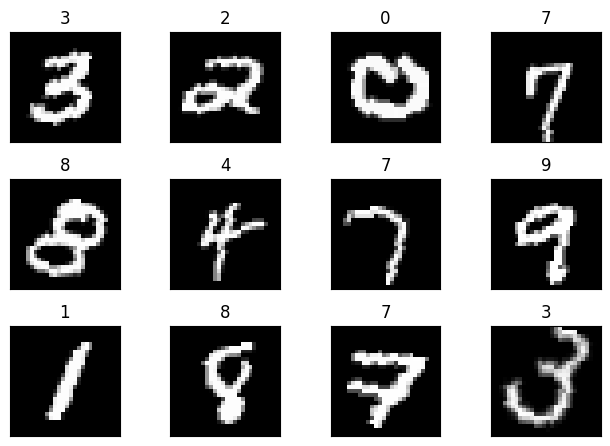

In [19]:
batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

# **Model Architecture**

In [25]:
  class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) #28x28x1  | (3x3x1)16 | 26x26x16 RF 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) #26x26x16 | (3x3x16)x32 | 24x24x32 RF 5x5
        self.conv3 = nn.Conv2d(32, 48, kernel_size=3) #12x12x32 | (3x3x32)x56 | 10x10x56 RF 12x12
        self.conv4 = nn.Conv2d(48, 24, kernel_size=1) #5x5x56 | (3x3x32)x10 | 5x5x32 RF 24x24
        self.fc1 = nn.Linear(24 * 5 * 5, 10) #RF 24x24

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv5(x))
        x = x.view(-1, 24 * 5 * 5)
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

In [131]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)  # 28x28x1 -> 28x28x32
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # 28x28x32 -> 28x28x64
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # 14x14x64 -> 14x14x128
        self.bn3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)  # 14x14x128 -> 14x14x256
        self.bn4 = nn.BatchNorm2d(256)
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 pooling
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(256 * 3 * 3, 128)  # Corrected: 256 * 3 * 3 = 2304
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.pool(x)  # 28x28x32 -> 14x14x32
        x = F.relu(self.bn2(self.conv2(x)))
        x = self.pool(x)  # 14x14x64 -> 7x7x64
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = self.pool(x)  # 14x14x256 -> 7x7x256 -> 3x3x256
        x = x.view(-1, 256 * 3 * 3)  # Corrected: [batch_size, 2304]
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [21]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

In [133]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion): # Added criterion here
    model.eval()

    test_loss = 0
    correct = 0

    # with torch.no_grad():
    #     for batch_idx, (data, target) in enumerate(test_loader):
    #         data, target = data.to(device), target.to(device)

    #         output = model(data)
    #         test_loss += criterion(output, target).item()  # Use criterion to calculate loss

    #         correct += GetCorrectPredCount(output, target)
    with torch.no_grad():
      for batch_idx, (data, target) in enumerate(test_loader):
          data, target = data.to(device), target.to(device)

          output = model(data)
          # Compute per-sample loss and sum it
          loss = criterion(output, target)  # Shape: [batch_size]
          test_loss += loss.sum().item()  # Sum the per-sample losses and add to test_loss

          correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [134]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=10.01, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 20

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, test_loader, criterion)
  scheduler.step()

cuda
Epoch 1


Train: Loss=3.5414 Batch_id=117 Accuracy=9.94: 100%|██████████| 118/118 [00:18<00:00,  6.45it/s]


Test set: Average loss: 0.0066, Accuracy: 6265/60000 (10.44%)

Epoch 2


Train: Loss=2.4732 Batch_id=117 Accuracy=10.03: 100%|██████████| 118/118 [00:18<00:00,  6.46it/s]


Test set: Average loss: 0.0046, Accuracy: 5958/60000 (9.93%)

Epoch 3


Train: Loss=2.3813 Batch_id=117 Accuracy=9.80: 100%|██████████| 118/118 [00:18<00:00,  6.28it/s]


Test set: Average loss: 0.0046, Accuracy: 6742/60000 (11.24%)

Epoch 4


Train: Loss=2.3409 Batch_id=117 Accuracy=10.28: 100%|██████████| 118/118 [00:19<00:00,  6.21it/s]


Test set: Average loss: 0.0046, Accuracy: 5918/60000 (9.86%)

Epoch 5


Train: Loss=2.3375 Batch_id=117 Accuracy=10.31: 100%|██████████| 118/118 [00:17<00:00,  6.56it/s]


Test set: Average loss: 0.0047, Accuracy: 5923/60000 (9.87%)

Epoch 6


Train: Loss=2.3861 Batch_id=117 Accuracy=9.98: 100%|██████████| 118/118 [00:17<00:00,  6.60it/s]


KeyboardInterrupt: 

In [17]:
device

'cuda'

In [4]:
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms

# Initialize global lists (if not already defined)
train_acc = []
train_losses = []
test_acc = []
test_losses = []

# Define GetCorrectPredCount
def GetCorrectPredCount(pPrediction, pLabels):
    return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

# Training function
def train(model, device, train_loader, optimizer, criterion):
    model.train()
    pbar = tqdm(train_loader)
    train_loss = 0
    correct = 0
    processed = 0

    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()

        # Predict
        pred = model(data)

        # Calculate loss
        loss = criterion(pred, target)  # Shape: [batch_size]
        train_loss += loss.sum().item()  # Sum per-sample losses for reporting
        loss = loss.mean()  # Average for backpropagation
        loss.backward()
        optimizer.step()

        correct += GetCorrectPredCount(pred, target)
        processed += len(data)

        pbar.set_description(desc=f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

    train_acc.append(100 * correct / processed)
    train_losses.append(train_loss / len(train_loader.dataset))  # Average per sample

# Test function
def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)  # Shape: [batch_size]
            test_loss += loss.sum().item()  # Sum per-sample losses
            correct += GetCorrectPredCount(output, target)

    test_loss /= len(test_loader.dataset)  # Average per sample
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

# Data preprocessing (for MNIST)
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.1407,), (0.4081,)) # Mean: 0.1307, Std: 0.3015 ,Total_images: 60000 . Normalization must be uniform between train and test.
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Load MNIST
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=True, download=True, transform=train_transforms),
    batch_size=512, shuffle=True
)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('./data', train=False, transform=test_transforms),
    batch_size=512, shuffle=False
)

class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        #self.conv1 = nn.Conv2d(1, 32, kernel_size=3) #28x28x1  | (3x3x1)x32 | 26x26x32 RF 3x3
        #self.conv2 = nn.Conv2d(32, 64, kernel_size=3) #26x26x32 | (3x3x32)x64 | 24x24x64 RF 5x5
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3) #28x28x1  | (3x3x1)x32 | 26x26x32 RF 3x3
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) #26x26x32 | (3x3x32)x64 | 24x24x64 RF 5x5
        self.conv3 = nn.Conv2d(32, 56, kernel_size=3) #26x26x32 | (3x3x32)x64 | 24x24x64 RF 5x5
        #self.conv3 = nn.Conv2d(64, 128, kernel_size=3) #24x24x64 | (3x3x64)x128 | 22x22x128 RF 7x7
        #self.conv4 = nn.Conv2d(56, 16, kernel_size=3) #22x22x128 | (3x3x128)x256 | 20x20x256 RF 9x9
        #self.conv5 = nn.Conv2d(256, 32, kernel_size=1) #10x10x256 | (1x1x256)x32 | 10x10x256 RF 11x11
        self.conv5 = nn.Conv2d(56, 10, kernel_size=1) #20x20x256 | (1x1x256)x32 | 20x20x256 RF 9x9
        #self.fc1 = nn.Linear(10 * 10 * 10, 10)
        self.fc1 = nn.Linear(10 * 5 * 5, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv3(x))
        #x = F.relu(self.conv4(x))
        x = F.max_pool2d(x, 2)
        #print(x.size())
        x = F.relu(self.conv5(x))
        #x = x.view(-1, 32 * 10 * 10)
        x = x.view(-1, 10 * 5 * 5)
        x = self.fc1(x)
        #x = self.fc2(x)
        #print(x.size())
        return F.log_softmax(x, dim=1)

# Setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)
criterion = nn.CrossEntropyLoss(reduction='none')
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.1)
num_epoch = 20
# Training loop for 10 epochs
for epoch in range(1, num_epoch+1):
    print(f'Epoch {epoch}')
    train(model, device, train_loader, optimizer, criterion)
    test(model, device, test_loader, criterion)
    scheduler.step()

Epoch 1


Train: Loss=0.1945 Batch_id=117 Accuracy=76.39: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.1559, Accuracy: 9529/10000 (95.29%)

Epoch 2


Train: Loss=0.1129 Batch_id=117 Accuracy=94.53: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.0891, Accuracy: 9727/10000 (97.27%)

Epoch 3


Train: Loss=0.2201 Batch_id=117 Accuracy=95.73: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.0826, Accuracy: 9749/10000 (97.49%)

Epoch 4


Train: Loss=0.0961 Batch_id=117 Accuracy=95.96: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.0797, Accuracy: 9754/10000 (97.54%)

Epoch 5


Train: Loss=0.2196 Batch_id=117 Accuracy=96.11: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s]


Test set: Average loss: 0.0787, Accuracy: 9749/10000 (97.49%)

Epoch 6


Train: Loss=0.1359 Batch_id=117 Accuracy=96.09: 100%|██████████| 118/118 [01:30<00:00,  1.31it/s]


Test set: Average loss: 0.0786, Accuracy: 9745/10000 (97.45%)

Epoch 7


Train: Loss=0.0611 Batch_id=117 Accuracy=96.04: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.0785, Accuracy: 9745/10000 (97.45%)

Epoch 8


Train: Loss=0.1704 Batch_id=117 Accuracy=96.03: 100%|██████████| 118/118 [01:31<00:00,  1.29it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 9


Train: Loss=0.1488 Batch_id=117 Accuracy=96.04: 100%|██████████| 118/118 [01:33<00:00,  1.26it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 10


Train: Loss=0.0812 Batch_id=117 Accuracy=96.13: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 11


Train: Loss=0.1493 Batch_id=117 Accuracy=96.09: 100%|██████████| 118/118 [01:33<00:00,  1.26it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 12


Train: Loss=0.0993 Batch_id=117 Accuracy=96.12: 100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 13


Train: Loss=0.1164 Batch_id=117 Accuracy=96.03: 100%|██████████| 118/118 [01:40<00:00,  1.18it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 14


Train: Loss=0.1094 Batch_id=117 Accuracy=96.02: 100%|██████████| 118/118 [01:31<00:00,  1.28it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 15


Train: Loss=0.0675 Batch_id=117 Accuracy=96.12: 100%|██████████| 118/118 [01:34<00:00,  1.25it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 16


Train: Loss=0.1171 Batch_id=117 Accuracy=96.19: 100%|██████████| 118/118 [01:37<00:00,  1.21it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 17


Train: Loss=0.1471 Batch_id=117 Accuracy=96.03: 100%|██████████| 118/118 [01:34<00:00,  1.24it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 18


Train: Loss=0.1225 Batch_id=117 Accuracy=96.09: 100%|██████████| 118/118 [01:32<00:00,  1.28it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 19


Train: Loss=0.1072 Batch_id=117 Accuracy=96.05: 100%|██████████| 118/118 [01:33<00:00,  1.26it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)

Epoch 20


Train: Loss=0.0858 Batch_id=117 Accuracy=96.02: 100%|██████████| 118/118 [01:30<00:00,  1.30it/s]


Test set: Average loss: 0.0784, Accuracy: 9747/10000 (97.47%)



Text(0.5, 1.0, 'Test Accuracy')

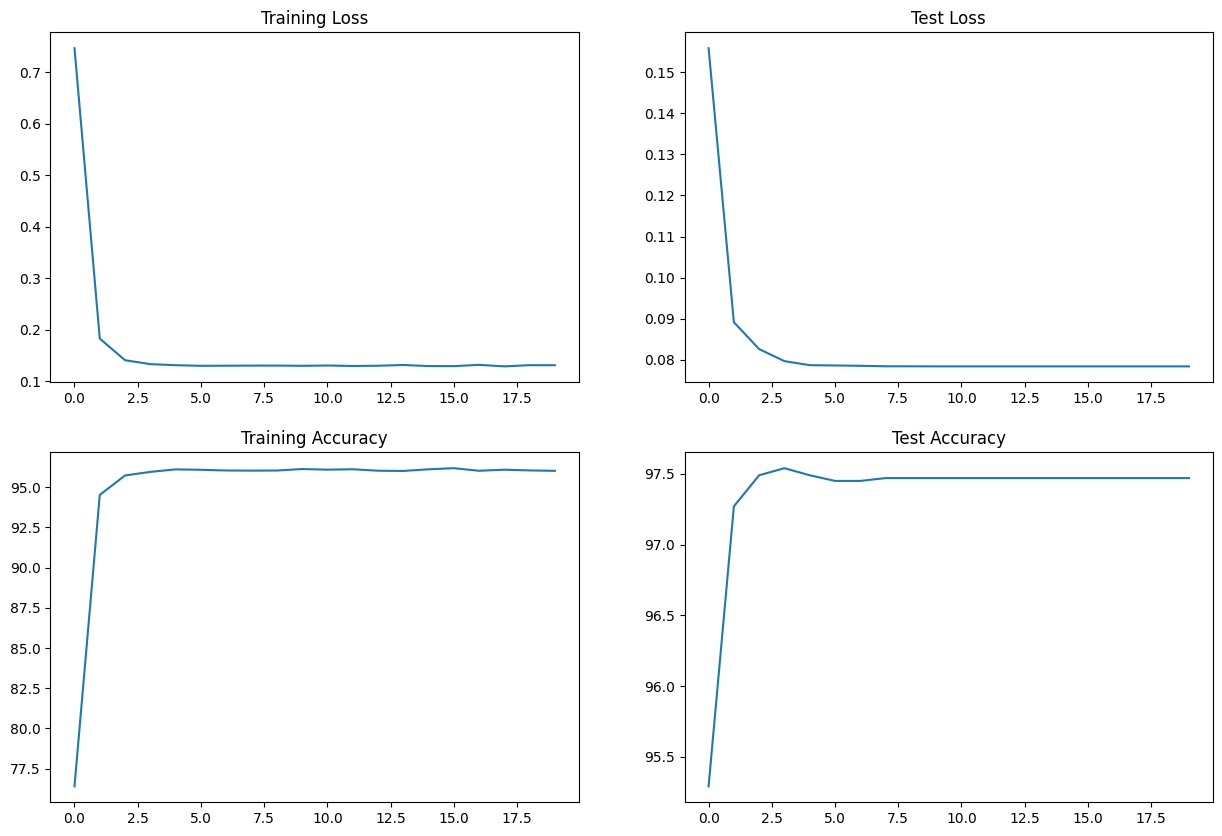

In [7]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
            Conv2d-2           [-1, 32, 24, 24]           4,640
            Conv2d-3           [-1, 56, 10, 10]          16,184
            Conv2d-4             [-1, 10, 5, 5]             570
            Linear-5                   [-1, 10]           2,510
Total params: 24,064
Trainable params: 24,064
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.27
Params size (MB): 0.09
Estimated Total Size (MB): 0.36
----------------------------------------------------------------
